<font size=6>__Part A__</font>

In [1]:
import pandas as pd
import numpy as np
from scipy import *
from matplotlib import pyplot as plt
import math
import seaborn as sns
from scipy import stats
import copy

In [50]:
#define polynomial features 
def polynomialFeatures(X, degree):
    num_of_rows = len(X)
    num_of_features = len(X[0])
    X_new = [] #Stores the entire polynomial calculations
    if(degree == 1):
        return X
    for r in range(num_of_rows):
        X_curr = [] #Stores the current polynomial degree calculations
        X_last = [] #Stores the last calculated polynomial degree. (ie. if it is currently on degree 5 this stores degree 4)
        index_to_start = [] #Stores the index of the last calculations (current feature)^(degree) (ie. if the feature is [a] and the degree is 4 then it stores the index of a^4)
        index_to_start_temp = []
        temp = []
        for i in X[r]:
            temp.append(i)
            X_last.append(i)
        #print(X_new)
        X_new.append(copy.deepcopy(temp))
        for i in range(num_of_features): #instantiates the indexes to start the calculations from in the X_last
            index_to_start.append(i)
            index_to_start_temp.append(i)
        for i in range(1,degree): #Compute each degree of the polinomial starting at 2 to the degree given
            for j in range(num_of_features): #Iterate through each feature in X
                for k in range(index_to_start[j],len(X_last)): #Iterate through the previous degree calculation starting at the (current feature)^(last degree)
                    X_curr.append(X_last[k]*X[r][j])
                if(j < num_of_features-1):
                    index_to_start_temp[j+1] = len(X_curr)
            #print('index_to_start:',index_to_start)
            #print('X_last:',X_last)
            #print('X_curr:',X_curr)
            X_last = []
            index_to_start = []
            for i in X_curr: #Set X_last to the values in X_curr and append the current calculated degree to the new list
                X_last.append(i)
                X_new[r].append(i)
            for i in index_to_start_temp: #Set the current calculated indexes to the new ones
                index_to_start.append(i)
            X_curr = []
    return X_new

In [3]:
def mse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    size = len(y_true)
    cost = 0
    for i in range(size):
        cost = cost + (y_true[i] - y_pred[i])**2
    return cost/size

In [111]:
def k_folds(X, cv):
    return [X[i::cv] for i in range(cv)]

def k_fold_mse(X, y, cv, model): # go horizontal
    train_set = []
    val_set = []
    y = y.to_numpy()
    y_train_true, y_train_pred = [], []
    y_val_true, y_val_pred = [], []
    mse_train, mse_val = [], []
    X_folds = k_folds(X, cv)
    y_folds = k_folds(y, cv)
    fold_len = math.ceil(len(X)/cv)
    for i in range(len(X_folds)):
        train_set = []
        val_set = []
        #compute mse of val and train set here
        val_set = X_folds[i]
        y_val_true = y_folds[i]
        y_val_pred = model.predict(val_set)
        start = i*fold_len
        fin = start+fold_len
        #X_train_set = X.drop(X.index[start:fin])
        X_train_set = np.delete(X,range(fold_len*i,fold_len*(i+1)),0)
        y_train_set = np.delete(y,range(fold_len*i,fold_len*(i+1)))
        #train_set.append(X_folds[j])
        #y_train_set.append(y_folds[j])
        y_train_pred = model.predict(X_train_set)   
        mse_train.append(mse(y_train_set, y_train_pred))
        mse_val.append(mse(y_val_true, y_val_pred))
    return (mse_train, mse_val)

In [5]:
def learning_curve(model, X, y, cv, train_size, learning_rate, epochs, tol, regularizer, lambd, **kwargs):
    if(train_size <= 1):
        train_size = math.ceil(len(X)*train_size)
    mse_train, mse_val = [], []
    mse_whole = []
    model.fit(X, y, learning_rate, epochs, tol, regularizer, lambd, **kwargs)
    for i in range(math.ceil(len(X)/train_size)):
        X_split, y_split = X[0:train_size*(i+1)], y[0:train_size*(i+1)]
        mse_whole = k_fold_mse(X_split, y_split, cv, model)
        mse_train.append(mse_whole[0])
        mse_val.append(mse_whole[1])
    return (np.sqrt(mse_train), np.sqrt(mse_val))

In [90]:
#Linear Regression
class Linear_Regression:
    def fit(self, X, y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        self.kwargs = kwargs
        X_rows = len(X[0])
        self.theta = zeros(X_rows)
        self.theta = copy.deepcopy(self.gradientDescent())
    def predict(self, X):
        #use theta*X to predict y
        return np.dot(X, self.theta)
    def gradientDescent(self):
        X = copy.deepcopy(self.X)
        X_T = np.transpose(self.X)
        y = copy.deepcopy(self.y)
        theta_hat = zeros(len(X[0]))
        cost_new = 0
        cost = 0
        m = len(y)
        for i in range(self.epochs):
            if regularizer == None:
                regularizer_term = 0
                regularizer_theta = 0
            elif regularizer == "l1":
                regularizer_term = (self.lambd/(2*m))*(sum(self.theta))
                regularizer_theta = (self.lambd/(2*m))*(np.sign(self.theta))
            else:
                regularizer_term = (self.lambd/(2*m))*(sum(self.theta)**2)
                regularizer_theta = self.theta*((self.learning_rate*self.lambd)/m)
            theta_hat = self.theta-(self.learning_rate/m)*np.dot(X_T, (np.dot(X, self.theta)-y)) - regularizer_theta
            cost_new = ((y-np.dot(X, theta_hat))**2)/(2*m)
            self.theta = copy.deepcopy(theta_hat)
            cost = cost_new + regularizer_term
            if self.tol == None:
                continue
            else:
                if (cost_new-cost) < self.tol:
                    return theta_hat
        return theta_hat
    def __init__(self):
        return None

<font size=6>__Part B__</font>

In [7]:
df = pd.read_csv("winequality-red.csv",sep=',')
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
df = df.sample(frac=1)
X = df.drop(columns=['quality'])
y = df['quality']
print(df.corr()['quality'].sort_values(ascending=False))

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


In [9]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1578,6.8,0.67,0.15,1.8,0.118,13.0,20.0,0.99540,3.42,0.67,11.3,6
428,9.1,0.52,0.33,1.3,0.070,9.0,30.0,0.99780,3.24,0.60,9.3,5
1320,9.7,0.66,0.34,2.6,0.094,12.0,88.0,0.99796,3.26,0.66,10.1,5
494,6.5,0.39,0.23,8.3,0.051,28.0,91.0,0.99520,3.44,0.55,12.1,6
475,9.6,0.68,0.24,2.2,0.087,5.0,28.0,0.99880,3.14,0.60,10.2,5


In [10]:
#partition function to split data into train and test
def partitions(X, y, t):
    test_rows_X = math.ceil(len(X)*t)
    test_rows_y = math.ceil(len(y)*t)
    train_rows_X = len(X) - test_rows_X
    train_rows_y = len(y) - test_rows_y
    X_train = X.iloc[:train_rows_X]
    X_test = X.iloc[train_rows_X:]
    y_train = y[0:train_rows_y]
    y_test = y[train_rows_y:len(y)]

    return np.asarray([X_train, y_train, X_test, y_test])
#partition(X, y, 0.2)

In [11]:
X_mean = np.mean(X.T)
X_std = np.std(X.T)

X_standard = ((X.T-X_mean)/(X_std)).T

par = partitions(X_standard, y, 0.2)
X_train = par[0]
y_train = par[1]
X_test = par[2]
y_test = par[3]

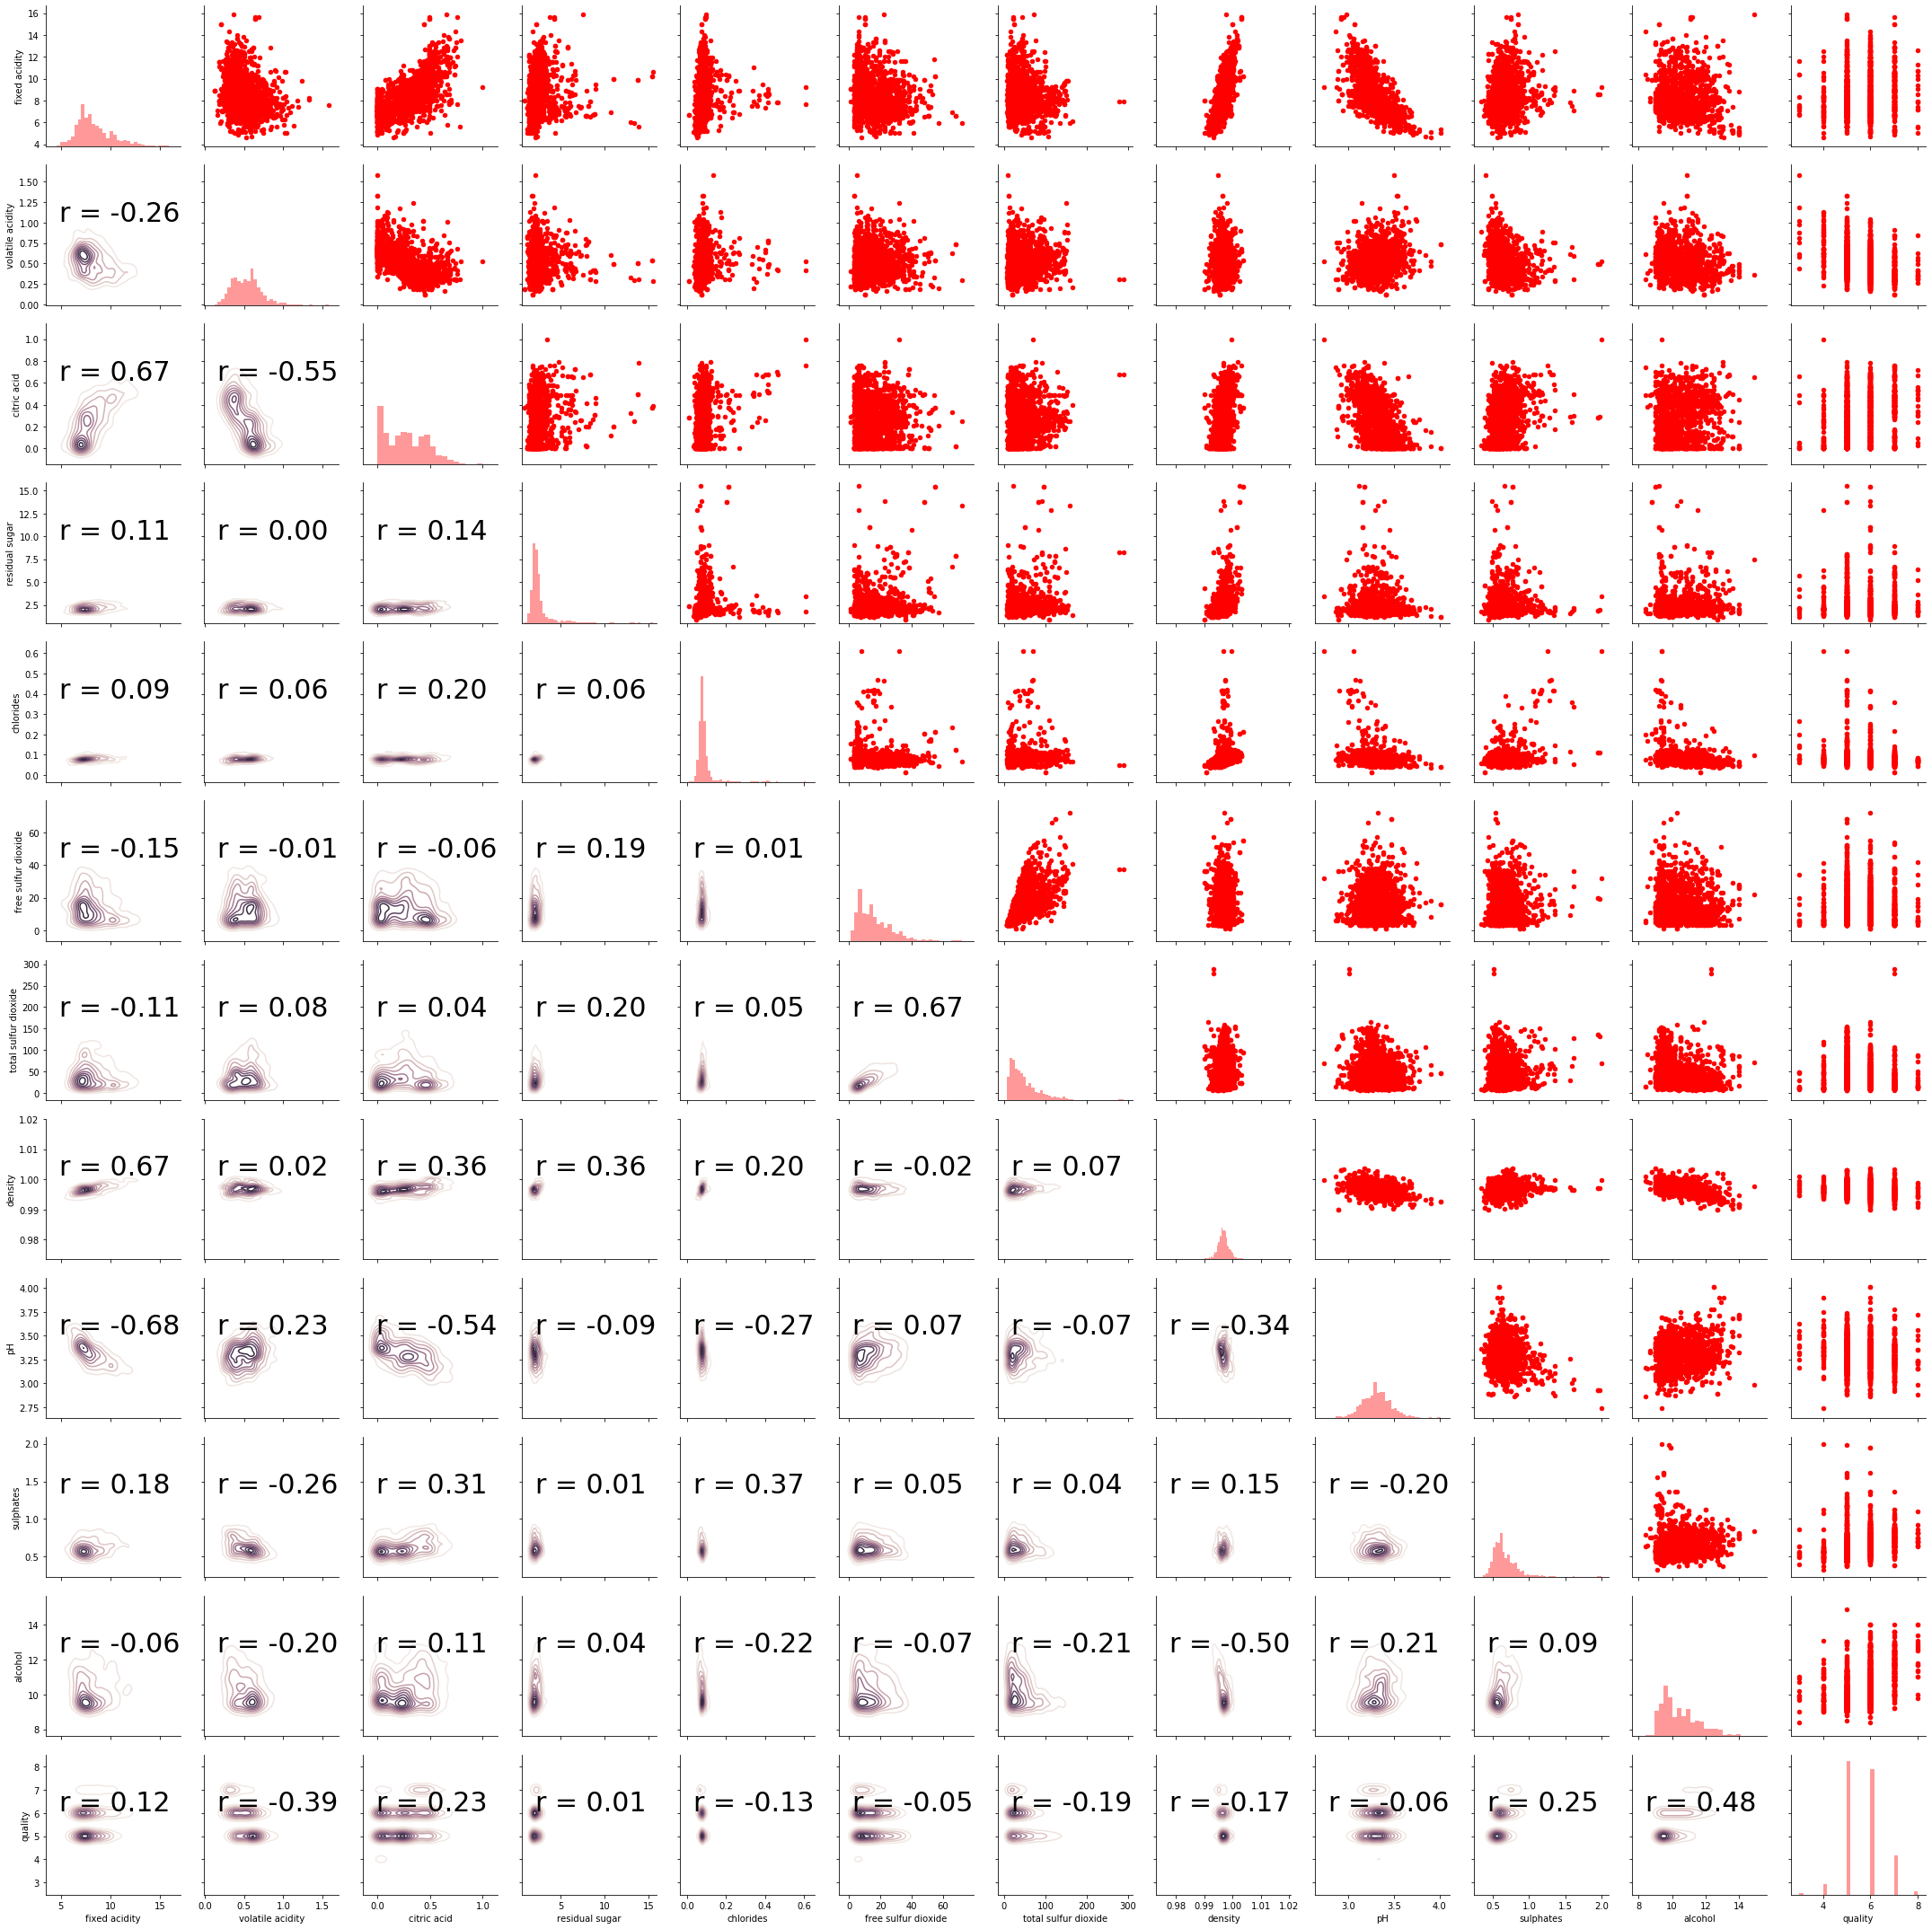

In [12]:
#generate pair plots for redundant features
def corrfunc(x, y, **kws):
    r,_ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
               xy=(.1, .6), xycoords=ax.transAxes,
               size = 30)
cmap = sns.cubehelix_palette(light=1, dark=0.1,
                            hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

g = sns.PairGrid(df)

g.map_upper(plt.scatter, s=20, color='red')

g.map_diag(sns.distplot, kde=False, color='red')

g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

<font size=6>__Part C__</font>

In [16]:
%%time
lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001]
learning_rate = [0.1, 0.01, 0.001, 0.001]
regularizer= ['l1', 'l2']
model = Linear_Regression()
combo = []
cv = 5
for i in range(len(lambd)):
    for j in range(len(learning_rate)):
        for k in range(len(regularizer)):
            model = Linear_Regression()
            model.fit(X_train, y_train, learning_rate[j], 1000, None, regularizer[k], lambd[i])
            k_fold_errors = k_fold_mse(X_train, y_train, cv, model)
            combo.append({'lambda': lambd[i], 'learning rate': learning_rate[j], 'regularizer': regularizer[k], 'mse_train': k_fold_errors[0], 'mse_val': k_fold_errors[1]})

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


CPU times: user 46.6 s, sys: 74.1 ms, total: 46.7 s
Wall time: 46.7 s


In [18]:
#print(combo[0].get('mse_val')[0])
# evaluate model on test data
optimal_model_index = 0
temp = math.inf
for i in range(len(combo)):
    if np.mean(combo[i].get("mse_val")) < temp:
        optimal_model_index = i
        temp = np.mean(combo[i].get("mse_val"))
optimal_lambd = combo[optimal_model_index].get('lambda')
optimal_learning_rate = combo[optimal_model_index].get('learning rate')
optimal_regularizer = combo[optimal_model_index].get('regularizer')
model_optimal = Linear_Regression()
model_optimal.fit(X_train, y_train, optimal_learning_rate, 1000, None, optimal_regularizer, optimal_lambd)
y_test_pred = model_optimal.predict(X_test)
test_mse = mse(y_test, y_test_pred)
print("The root mean squared error of test data is: ", test_mse)

The root mean squared error of test data is:  0.579597540777762


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


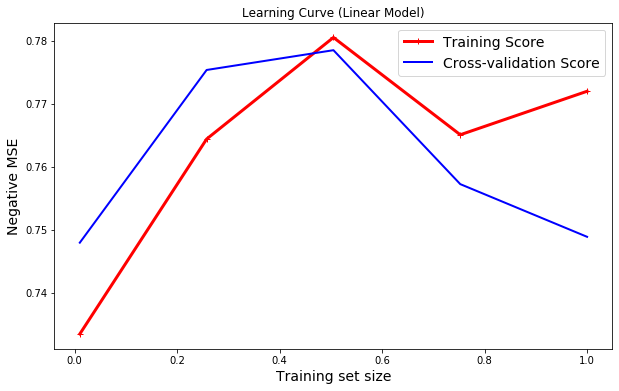

In [24]:
train_size = .2
train_sizes = np.linspace(0.01, 1, 5)
train_scores, val_scores = learning_curve(model_optimal, X_train, y_train, 5, train_size, optimal_learning_rate, 1000, None, optimal_regularizer, optimal_lambd)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()

In [112]:
%%time
degree = 3
X_train_poly = polynomialFeatures(X_train.to_numpy(), degree)
lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001]
learning_rate = [0.1, 0.01, 0.001, 0.001]
regularizer= ['l1', 'l2']
model_poly = Linear_Regression()
combo_poly = []
cv = 5
for i in range(len(lambd)):
    for j in range(len(learning_rate)):
        for k in range(len(regularizer)):
            model_poly = Linear_Regression()
            model_poly.fit(X_train_poly, y_train, learning_rate[j], 1000, None, regularizer[k], lambd[i])
            k_fold_errors = k_fold_mse(X_train_poly, y_train, cv, model_poly)
            combo_poly.append({'lambda': lambd[i], 'learning rate': learning_rate[j], 'regularizer': regularizer[k], 'mse_train': k_fold_errors[0], 'mse_val': k_fold_errors[1]})

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


CPU times: user 5h 34min 16s, sys: 2min 13s, total: 5h 36min 29s
Wall time: 1h 24min 44s


In [114]:
# Find the optimal value for the polynomial model
optimal_model_poly_index = 0
temp = math.inf
for i in range(len(combo)):
    if np.mean(combo[i].get("mse_val")) < temp:
        optimal_model_poly_index = i
        temp = np.mean(combo_poly[i].get("mse_val"))
optimal_lambd_poly = combo_poly[optimal_model_poly_index].get('lambda')
optimal_learning_rate_poly = combo_poly[optimal_model_poly_index].get('learning rate')
optimal_regularizer_poly = combo_poly[optimal_model_poly_index].get('regularizer')
model_poly_optimal = Linear_Regression()
model_poly_optimal.fit(X_train.to_numpy(), y_train, optimal_learning_rate_poly, 1000, None, optimal_regularizer_poly, optimal_lambd_poly)
y_test_pred_poly = model_poly_optimal.predict(X_test)
test_mse_poly = mse(y_test, y_test_pred_poly)
print("The root mean squared error of test data is: ", test_mse_poly)

The root mean squared error of test data is:  0.5813865817286341


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


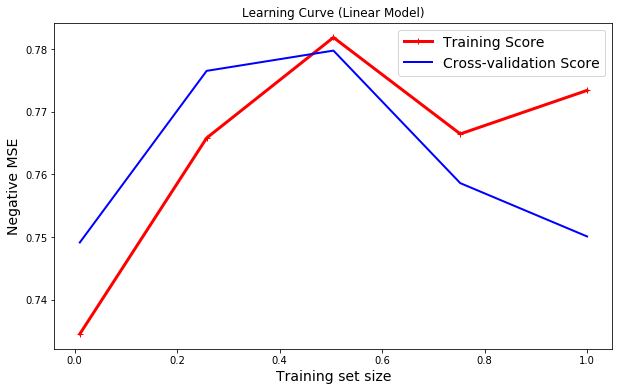

In [116]:
train_size = .2
train_sizes = np.linspace(0.01, 1, 5)
train_scores_poly, val_scores_poly = learning_curve(model_poly_optimal, X_train.to_numpy(), y_train, 5, train_size, optimal_learning_rate_poly, 1000, None, optimal_regularizer_poly, optimal_lambd_poly)

train_mean_poly = np.mean(train_scores_poly, axis=1)
train_std_poly = np.std(train_scores_poly, axis=1)

val_mean_poly = np.mean(val_scores_poly, axis=1)
val_std_poly = np.std(val_scores_poly, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean_poly, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean_poly, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()